# PyTorch quickstart

## Welcome to PrimeHub!

In this quickstart, we will perfome following actions to train and deploy the model: 

1. Train a neural network that classifies images.
1. Move trained model to <a target="_blank" href="https://docs.primehub.io/docs/quickstart/nb-data-store#phfs-storage">PHFS Storage</a>.
1. Deploy the trained model on PrimeHub <a target="_blank" href="https://docs.primehub.io/docs/model-deployment-feature">Model Deployments</a>.
1. Test deployed model.

### Prerequisites
1. Enable <a target="_blank" href="https://docs.primehub.io/docs/model-deployment-feature">Model Deployments</a>.
1. Enable <a target="_blank" href="https://docs.primehub.io/docs/quickstart/nb-data-store#phfs-storage">PHFS Storage</a>.

**Contact your admin if any prerequisite is not enabled yet.**

## 1. Train a neural network that classifies images

Firstly, let's import libraries.

In [1]:
import os
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

Load and prepare the MNIST dataset. Convert the samples to tensor and normalize them.

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
!rm MNIST.tar.gz

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_train = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
mnist_test = DataLoader(mnist_test, batch_size=64)

--2021-08-24 03:54:36--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-08-24 03:54:37--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  5.35MB/s    in 19s     

2021-08-24 03:54:56 (1.78 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

Set device on GPU if available, else CPU.

In [3]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(torch.cuda.device(device))
    print('Device Count:', torch.cuda.device_count())
    print('Device Name: {}'.format(torch.cuda.get_device_name(device)))
else:
    device = 'cpu'

Build the model class.

In [4]:
class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.softmax(x, dim=1)
        return x

Create the model instance.

In [5]:
net = PyTorchModel().to(device)

Choose an optimizer, loss function.

In [6]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

Train the model to minimize the loss. It prints the loss every 200 mini-batches.

In [7]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(mnist_train, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 199))
            running_loss = 0.0

[1,   200] loss: -0.697
[1,   400] loss: -0.898
[1,   600] loss: -0.916
[1,   800] loss: -0.930
[2,   200] loss: -0.941
[2,   400] loss: -0.947
[2,   600] loss: -0.955
[2,   800] loss: -0.952


Use the test data to check the model performance.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in mnist_test:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print("Accuracy of the network on the %d test images: %d %%" % (total, 100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


Save the trained model.

In [9]:
now = datetime.now()
date_time = now.strftime("%Y%m%d-%H%M%S")
SAVED_DIR = f"pytorch-model-{date_time}"
os.makedirs(SAVED_DIR, exist_ok=True)
torch.save(net.state_dict(), os.path.join(SAVED_DIR, "model.pt"))
print(f"We successfully saved the model in {SAVED_DIR}.")

We successfully saved the model in pytorch-model-20210824-035559.


Save the model class file. The class name must be `PyTorchModel`. The content is the model class content and the imports used in the class.

In [10]:
model_class_file_content = """
import torch
from torch.nn import functional as F
from torch import nn

class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.softmax(x, dim=1)
        return x
"""
model_class_file = open(os.path.join(SAVED_DIR, "ModelClass.py"), "w")
model_class_file.write(model_class_file_content)
model_class_file.close()
print(f"We successfully saved the model class file in {SAVED_DIR}.")

We successfully saved the model class file in pytorch-model-20210824-035559.


## 2. Move trained model to <a target="_blank" href="https://docs.primehub.io/docs/quickstart/nb-data-store#phfs-storage">PHFS Storage</a>

To deploy our model, we need to move model to PHFS storage.

In [11]:
!mv $SAVED_DIR ~/phfs

Check the model under PHFS storage.

In [12]:
!ls -l ~/phfs/$SAVED_DIR

total 540
-rw-r--r-- 1 jovyan users    690 Aug 24 03:55 ModelClass.py
-rw-r--r-- 1 jovyan users 546597 Aug 24 03:55 model.pt


## 3. Deploy the trained model on PrimeHub <a target="_blank" href="https://docs.primehub.io/docs/model-deployment-feature">Model Deployments</a>

In [13]:
print(f"Now, we've already prepared the ready-to-deploy model in ~/phfs/{SAVED_DIR}.")

Now, we've already prepared the ready-to-deploy model in ~/phfs/pytorch-model-20210824-035559.


Next, back to PrimeHub and select `Deployments`.

<img src="img/pytorch/3-1-menu.png"/>

In the `Deployments` page, click on `Create Deployment` button.

<img src="img/pytorch/3-2-create-deployment.png"/>

1. Fill in the [Deployment Name] field with [pytorch-quickstart].
1. Select the [Model Image] field with [PyTorch server]; this is a pre-packaged model server image that can serve PyTorch model.

<img src="img/pytorch/3-3-name-model-image.png"/>

In [14]:
print(f"Fill in the [Model URI] field with [phfs:///{SAVED_DIR}].")

Fill in the [Model URI] field with [phfs:///pytorch-model-20210824-035559].


<img src="img/pytorch/3-4-model-uri.png"/>

Choose the Instance Type, the minimal requirements in this quickstart is `CPU: 0.5 / Memory: 1 G / GPU: 0`.

<img src="img/pytorch/3-5-resource.png"/>

Then, click on `Deploy` button.

Our model is deploying, let's click on the `pytorch-quickstart` deployment cell.

<img src="img/pytorch/3-6-deployment-list.png"/>

In the deployment detail page, we can see the `Status` is `Deploying`.

<img src="img/pytorch/3-7-deploying.png"/>

Wait for a while and our model is `Deployed` now!

To test our deployment, let's copy the value of `Endpoint` (`https://.../predictions`).

<img src="img/pytorch/3-8-deployed.png"/>

## 4. Test deployed model

Before testing, let's display the test image. It is a 28x28 grayscale image represented as numpy.ndarray.

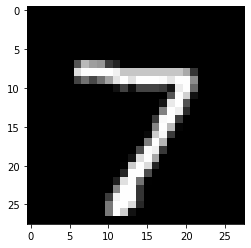

In [15]:
array = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32941176470588235, 0.7254901960784313, 0.6235294117647059, 0.592156862745098, 0.23529411764705882, 0.1411764705882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882352941177, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9450980392156862, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.6666666666666666, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2627450980392157, 0.4470588235294118, 0.2823529411764706, 0.4470588235294118, 0.6392156862745098, 0.8901960784313725, 0.996078431372549, 0.8823529411764706, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9803921568627451, 0.8980392156862745, 0.996078431372549, 0.996078431372549, 0.5490196078431373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.25882352941176473, 0.054901960784313725, 0.2627450980392157, 0.2627450980392157, 0.2627450980392157, 0.23137254901960785, 0.08235294117647059, 0.9254901960784314, 0.996078431372549, 0.41568627450980394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3254901960784314, 0.9921568627450981, 0.8196078431372549, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627450980392157, 0.9137254901960784, 1.0, 0.3254901960784314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823529411764, 0.996078431372549, 0.9333333333333333, 0.17254901960784313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137254901960785, 0.9764705882352941, 0.996078431372549, 0.24313725490196078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.7333333333333333, 0.0196078431372549, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882, 0.803921568627451, 0.9725490196078431, 0.22745098039215686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49411764705882355, 0.996078431372549, 0.7137254901960784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411764705882354, 0.984313725490196, 0.9411764705882353, 0.2235294117647059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980392156863, 0.8666666666666667, 0.996078431372549, 0.6509803921568628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.796078431372549, 0.996078431372549, 0.8588235294117647, 0.13725490196078433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901960784313725, 0.996078431372549, 0.996078431372549, 0.30196078431372547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862745098039, 0.8784313725490196, 0.996078431372549, 0.45098039215686275, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23921568627450981, 0.9490196078431372, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.996078431372549, 0.8588235294117647, 0.1568627450980392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.8117647058823529, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
plt.imshow(array, cmap='gray')
plt.show()

Then, replace the `<MODEL_DEPLOYMENT_ENDPOINT>` in the below cell with `https://.../predictions` (Endpoint value copied from deployment detail page).

In [ ]:
%env ENDPOINT=<MODEL_DEPLOYMENT_ENDPOINT>

Run below cell to send request to deployed model endpoint.

In [17]:
response=!curl -X POST $ENDPOINT \
    -H 'Content-Type: application/json' \
    -d '{ "data": {"ndarray": [[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32941176470588235, 0.7254901960784313, 0.6235294117647059, 0.592156862745098, 0.23529411764705882, 0.1411764705882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8705882352941177, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9450980392156862, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.7764705882352941, 0.6666666666666666, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2627450980392157, 0.4470588235294118, 0.2823529411764706, 0.4470588235294118, 0.6392156862745098, 0.8901960784313725, 0.996078431372549, 0.8823529411764706, 0.996078431372549, 0.996078431372549, 0.996078431372549, 0.9803921568627451, 0.8980392156862745, 0.996078431372549, 0.996078431372549, 0.5490196078431373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.25882352941176473, 0.054901960784313725, 0.2627450980392157, 0.2627450980392157, 0.2627450980392157, 0.23137254901960785, 0.08235294117647059, 0.9254901960784314, 0.996078431372549, 0.41568627450980394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3254901960784314, 0.9921568627450981, 0.8196078431372549, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08627450980392157, 0.9137254901960784, 1.0, 0.3254901960784314, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5058823529411764, 0.996078431372549, 0.9333333333333333, 0.17254901960784313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23137254901960785, 0.9764705882352941, 0.996078431372549, 0.24313725490196078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.7333333333333333, 0.0196078431372549, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882, 0.803921568627451, 0.9725490196078431, 0.22745098039215686, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49411764705882355, 0.996078431372549, 0.7137254901960784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29411764705882354, 0.984313725490196, 0.9411764705882353, 0.2235294117647059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07450980392156863, 0.8666666666666667, 0.996078431372549, 0.6509803921568628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.796078431372549, 0.996078431372549, 0.8588235294117647, 0.13725490196078433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14901960784313725, 0.996078431372549, 0.996078431372549, 0.30196078431372547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12156862745098039, 0.8784313725490196, 0.996078431372549, 0.45098039215686275, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5215686274509804, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23921568627450981, 0.9490196078431372, 0.996078431372549, 0.996078431372549, 0.20392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.996078431372549, 0.8588235294117647, 0.1568627450980392, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4745098039215686, 0.996078431372549, 0.8117647058823529, 0.07058823529411765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]] } }'

In the following cells, we will parse the model response to find the highest prediction probability.

In [18]:
result = json.loads(response[-1])

Print out response data.

In [19]:
result

{'data': {'names': [],
  'ndarray': [[0.0001399815228069201,
    9.203102990795742e-08,
    0.00012574432184919715,
    0.00014353565347846597,
    1.5619027848856604e-08,
    4.09758058594889e-06,
    1.4234747602870357e-08,
    0.9995245933532715,
    3.0489181881421246e-05,
    3.144729635096155e-05]]},
 'meta': {'requestPath': {'model': 'infuseai/pytorch-prepackaged:v0.2.0'}}}

In [20]:
print(f"The model predicts the number is {np.argmax(result['data']['ndarray'][0])}")

The model predicts the number is 7


Congratulations!

We have trained a model in Notebook and deployed it as an endpoint service that can respond to requests anytime from everywhere!